# Lending Club Loan Default Analysis

In this analysis we will review Lending Club loan data to understand what causes loans to default and charge off, and to contextualize these factors so that they can be factored into risk management strategies going forward.

In [2]:
#Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [3]:
#Load the dataset from the zipped file
df = pd.read_csv('loan.zip')

In [4]:
#Preview the Loan df
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Now that we have the data, we'll need to perform some initial cleaning in order to support our analysis.

In [5]:
#Clean the data

#Remove the % and convert to float
df['revol_util'] = df['revol_util'].str.replace('%', '')
df['revol_util'] = df['revol_util'].astype(float)

In [6]:
#Convert n/a's to 0's to enable statistical analysis
df['emp_length'] = df['emp_length'].fillna(0)

In [7]:
#Strip string text from the column to leave only the numeric years
df['emp_length'] = df['emp_length'].str.extract('(\d+)', expand=False)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/x4/87dx15b933dcrrmqqfysjws00000gr/T/ipykernel_12961/2249784678.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['emp_length'] = df['emp_length'].str.extract('(\d+)', expand=False)


First, lets take a look at what % of loans are paid, current, and charge-off so that we can begin diving into default risk analysis.

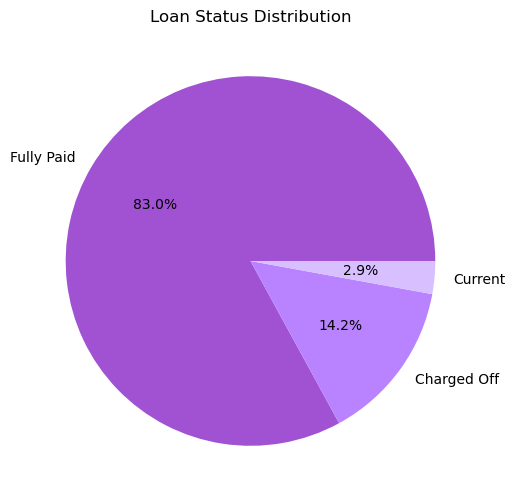

In [25]:
#Counts for each Loan Status
mode_counts = df['loan_status'].value_counts()

purple_colors = ['#A052D3', '#B983FF', '#D8BFFF', '#EBD8FF'] 

#Pie chart of Loan Status
plt.figure(figsize=(6, 6))
plt.pie(mode_counts, labels=mode_counts.index, autopct='%1.1f%%', colors=purple_colors)
plt.title('Loan Status Distribution')
plt.show()

Here we find that:
- 83% of loans are Fully Paid
- 3% are current
- and 14% are Charged Off

Our analysis will focus on better understandig the Charged Off % to understand the contributiing factors.

In order to perform correlation analysis we need to do some data mapping in order to convert qualitative columns to numerics so they can be processed using the corr() function.

In [10]:
# Create a dictionary to map strings to numbers to support correlation analysis for loan status
loan_status_mapping = {'Charged Off': 10, 'Current': 5, 'Fully Paid': 0}

# Create the new column using the map() method
df['loan_status_code'] = df['loan_status'].map(loan_status_mapping)

In [11]:
# Create a dictionary to map strings to numbers to support correlation analysis for loan sub-grade
sub_grade_mapping = {'A1': 100, 'A2': 99, 'A3': 98, 'A4': 97, 'A5': 96, 'B1': 95, 'B2': 94,
                'B3': 93, 'B4': 92, 'B5': 91, 'C1': 90, 'C2': 89, 'C3': 88, 'C4': 87,
                'C5': 86, 'D1': 85, 'D2': 84, 'D3': 83, 'D4': 82, 'D5': 81, 'E1': 80,
                'E2': 79, 'E3': 78, 'E4': 77, 'E5': 76, 'G1': 75, 'G2': 74, 'G3': 73,
                'G4': 72, 'G5': 71}

# Create the new column using the map() method
df['sub_grade_code'] = df['sub_grade'].map(sub_grade_mapping)

In [12]:
# Create a dictionary to map strings to numbers to support correlation analysis for home ownership
home_mapping = {'OWN': 10, 'MORTGAGE': 5, 'RENT': 3, 'OTHER': 1, 'NONE': 0}

# Create the new column using the map() method
df['home_code'] = df['home_ownership'].map(home_mapping)

Using this data we can produce a Correlation Heatmap to identify the top factors linked to loan status and potential default: 

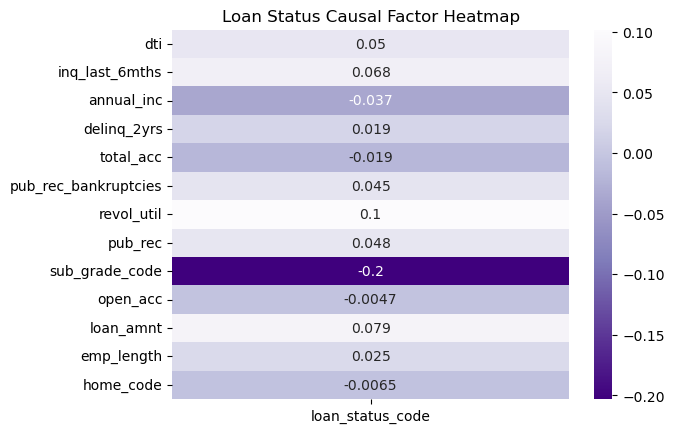

In [22]:
target_column = 'loan_status_code'
subset_columns = ['dti', 'inq_last_6mths', 'annual_inc', 'delinq_2yrs', 'total_acc', 
                  'pub_rec_bankruptcies', 'revol_util', 'pub_rec', 'sub_grade_code', 
                  'open_acc', 'loan_amnt', 'emp_length', 'home_code']
correlations = df[subset_columns + [target_column]].corr()

# Create heatmap
sns.heatmap(correlations.loc[subset_columns, [target_column]], annot=True, cmap='Purples_r')
plt.title('Loan Status Causal Factor Heatmap')
plt.show()

Here we can see that the loans sub-grade had the highest correlation with risk of charging off relative to other factors.

<Axes: xlabel='loan_status', ylabel='sub_grade_code'>

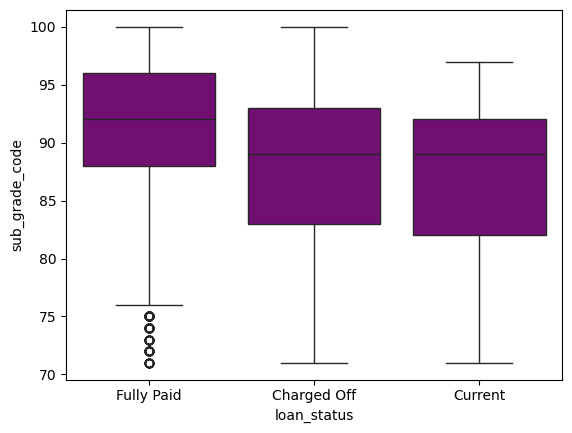

In [19]:
#Create a boxplot to compare Sub-Grade by Loan Status
sns.boxplot(x=df['loan_status'], y=df['sub_grade_code'], color='purple')

This plot demonstrates that Charged Off has a lower Bottom Band, Average, and Top Band for Sub_Grade_Code than Fully Paid.

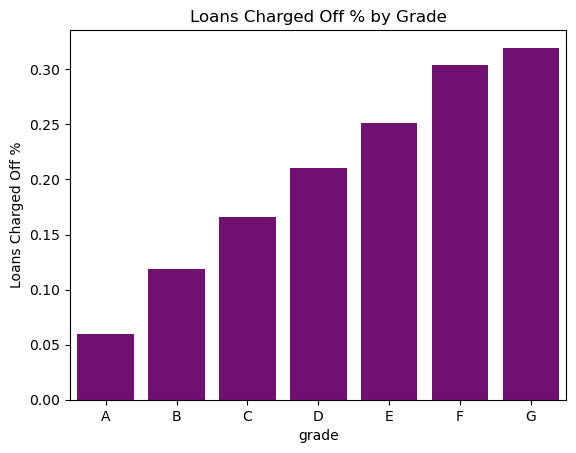

In [26]:
#Look at the Charge Off % by Grade to use for analysis
charge_off_pcnt_grade = df.groupby('grade')['loan_status'].value_counts(normalize=True)[:,'Charged Off']

sns.barplot(x=charge_off_pcnt_grade.index, y=charge_off_pcnt_grade.values, color='purple') \
.set_ylabel('Loans Charged Off %')
plt.title('Loans Charged Off % by Grade')
plt.show()

Here we can see a linear relationship where as the grade increases so does the loan charged off %. From the data we can see that customers with a A credit greade only have an ~5% charge-off rate vs. those with a F grade increase up to a ~30% risk.

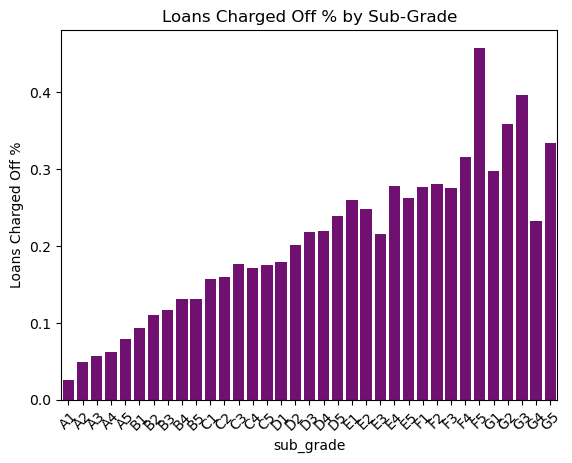

In [25]:
#Look at the Charge Off % by Sub-Grade to use for analysis
charge_off_pcnt_sub_grade = df.groupby('sub_grade')['loan_status'].value_counts(normalize=True)[:,'Charged Off']

sns.barplot(x=charge_off_pcnt_sub_grade.index, y=charge_off_pcnt_sub_grade.values, color='purple') \
.set_ylabel('Loans Charged Off %')
plt.title('Loans Charged Off % by Sub-Grade')
plt.xticks(rotation=45)
plt.show()

Similarly, we see a linear relationship where as the sub-grade increases so does the loan charged off %.

In [15]:
df['revol_util_rounded'] = df['revol_util'].round()

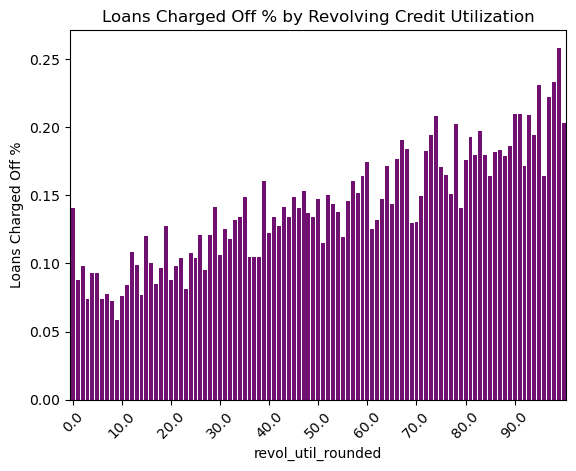

In [34]:
#Look at the Charge Off % by Revolving Credit Utilization to use for analysis
charge_off_pcnt_revol_util = df.groupby('revol_util_rounded')['loan_status'].value_counts(normalize=True)[:,'Charged Off']

sns.barplot(x=charge_off_pcnt_revol_util.index, y=charge_off_pcnt_revol_util.values, color='purple') \
.set_ylabel('Loans Charged Off %')
plt.title('Loans Charged Off % by Revolving Credit Utilization')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 100, 10))
plt.show()

While not as strong as Grade and Sub-Grade we do see a similar relationship where as the revolving credit utilization increases so does the loan charged off %. From the data we can see that customers with a 10% credit utilization only have an ~10% charge-off rate vs. those with 90% utilization increase up to a ~20% risk.